# 自己符号化器で通信系をモデリングする（AWGN通信路）

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/wadayama/MIKA2019/blob/master/autoencoder.ipynb)

## 必要なライブラリをインポートする

In [41]:
import torch
import math
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

## グローバル定数の設定

In [42]:
M   = 8 # 信号点数
mbs = 100 # ミニバッチ数
num_hidden_units = 10 #隠れ層のユニット数
sigma = 0.1 # 通信路雑音の標準偏差

## One-hotベクトル(長さ$n$)をランダムに生成する (ミニバッチ生成関数)

In [43]:
one_hot_generator = torch.distributions.OneHotCategorical((1.0/M)*torch.ones(mbs, M))
def gen_minibatch():
    return one_hot_generator.sample()

## ネットワークの定義

In [44]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.enc1 = nn.Linear(M, num_hidden_units) # 符号化器用レイヤー
        self.enc2 = nn.Linear(num_hidden_units, 2) # 符号化器用レイヤー
        self.dec1 = nn.Linear(2, num_hidden_units) # 復号器用レイヤー
        self.dec2 = nn.Linear(num_hidden_units, M) # 復号器用レイヤー
    def normalize(self, x): # 送信信号の正規化
        # 等電力制約
        #norm = torch.norm(x,dim=1).view(mbs, 1).expand(-1, 2) # Normalization layer
        #x = x/norm
        # 平均エネルギー制約
        norm = torch.sqrt((x.norm(dim=1)**2).sum()/mbs)
        x = x/norm
        return x
    def forward(self, m):
        s = torch.relu(self.enc1(m))
        s = self.enc2(s)
        x = self.normalize(s) # normalization 
        y = x + torch.normal(torch.zeros(mbs, 2), std=sigma) # AWGN通信路
        s = torch.relu(self.dec1(y))
        m_hat = torch.softmax(self.dec2(s), dim=1)
        return m_hat, y, x

## 訓練ループ

In [45]:
model = Net()
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
for i in range(5000):
    m = gen_minibatch()
    optimizer.zero_grad()
    m_hat, _, _ = model(m)
    loss = loss_func(m_hat, m)
    loss.backward()  
    optimizer.step()  
    if i % 1000 == 0:
        print(i, loss.item())

0 0.10953223705291748
1000 3.1392413802677765e-05
2000 6.552595550601836e-06
3000 1.99269488803111e-05
4000 1.2442143315638532e-06


## 再現実験

In [46]:
m = gen_minibatch()
m_hat, y, x = model(m)
x_re = x[:, 0].detach().numpy()
x_im = x[:, 1].detach().numpy()
y_re = y[:, 0].detach().numpy()
y_im = y[:, 1].detach().numpy()

## 送信信号点配置を表示

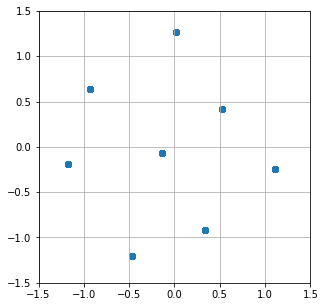

In [47]:
plt.figure(figsize=(5,5))
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
plt.grid()
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_re, x_im)

## 受信信号点を表示

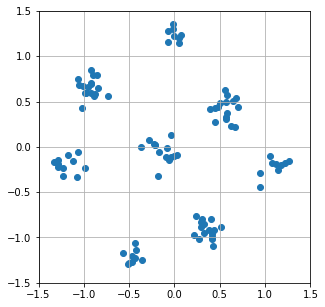

In [48]:
plt.figure(figsize=(5,5))
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
plt.grid()
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(y_re, y_im)